In [1]:
#import numpy as np
#from google.colab import drive
#drive.mount('/content/drive/')

#%cd drive/'My Drive/YYY_deep_project_YYY/transformers_example/'
#%ls 

In [2]:
# Takes in a pandas Series object and returns pytorch tensors
# for the train and test sets
def build_data(series, min_len = 3, max_len = 140):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # all sequences between `min_len` and `max_len`
    series = series[(series.str.len() > min_len) & (series.str.len() < max_len)] 

    # Preprocess strings into tensors of char ascii indexes
    inputs  = torch.zeros((len(series), max_len)).to(torch.long).to(device)
    targets = torch.zeros((len(series), max_len)).to(torch.long).to(device)

    for i, word in enumerate(series):
        try: word.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError: continue
        inputs[i,  0:len(word)]   = torch.from_numpy(np.frombuffer(str.encode(word), np.uint8).copy())
        targets[i, 0:len(word)-1] = torch.from_numpy(np.frombuffer(str.encode(word[1:]), np.uint8).copy())
        targets[i, len(word)-1]   = 1  # <EOS> token

    # Split into train and test dataset
    combined = torch.stack([inputs, targets], dim=1)
    train_size = int(0.8 * len(combined))
    test_size = len(combined) - train_size
    train_ds, test_ds = torch.utils.data.random_split(combined, [train_size, test_size])

    train_x, train_y = combined[train_ds.indices][:, 0, :], combined[train_ds.indices][:, 1, :]
    test_x, test_y   = combined[test_ds.indices][:, 0, :],  combined[test_ds.indices][:, 1, :]

    return train_x, train_y, test_x, test_y


In [4]:
import torch, sys
import pandas as pd
import numpy as np  
from torch import nn
import torch.nn.functional as F
from model import Transformer, sample_sentence
from model import colors as c

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate, batch_size, epochs = 1e-3, 256, 512

# loads the `word` column of `unigram_freq.csv` and lower-cases it.
series = pd.read_csv('unigram_freq.csv')['word'].str[:2**13]

max_len = int(max(series.str.len()))

print(max_len)
train_x, train_y, test_x, test_y = build_data(series, min_len = 3, max_len = max_len)
max_index = int(max(train_x.max(), test_x.max()))

args = {
    'emb_dim':        16,            # Embedding vector dimension
    'n_att_heads':    4,             # Number of attention heads for each transformer block
    'n_transformers': 4,             # Depth of the network (nr. of self-attention layers)
    'seq_length':     max_len,       # Sequence length
    'num_tokens':     max_index + 1, # Vocabulary size (highest index found in dataset)
    'device':         device,        # Device: cuda/cpu
    'wide':           False          # Narrow or wide self-attention
}



38


In [ ]:
stats = { 'loss': [], 'perplexity': [] } # we accomulate and save training statistics here
model = Transformer(**args).to(device)
opt   = torch.optim.Adam(lr=learning_rate, params=model.parameters())

for i in range(epochs):
    model.train()
    opt.zero_grad()
    
    # Sample a random batch of size `batch_size` from the train dataset
    idxs = torch.randint(size=(batch_size,), low=0, high=len(train_x))
    
    output, (emb_mean, emb_max) = model(train_x[idxs])
    loss = F.nll_loss(output, train_y[idxs], reduction='mean')
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    loss.backward()
    opt.step()
    
    # Calculate perplexity on the test-set
    model.eval()
    output_test, _ = model(test_x)
    loss_on_test   = F.nll_loss(output_test, test_y, reduction='mean')
    perplexity     = torch.exp(loss_on_test).item()

    # Update the stats and print something.
    stats['loss'].append(loss.item())
    stats['perplexity'].append(perplexity)
    
    sampled  = sample_sentence(model, "z", max_len = max_len, temperature = 0.5)
    
    to_print = [
        f"{c.HEADER}EPOCH %03d"        % i,
        f"{c.OKBLUE}LOSS %4.4f"        % stats['loss'][-1],
        f"{c.OKGREEN}PERPLEXITY %4.4f" % stats['perplexity'][-1],
        f"\t{c.OKCYAN}%s{c.ENDC}"      % sampled
    ]
    print(" ".join(to_print))

# Finally, save everyting:
torch.save({
    'state_dict':   model.state_dict(), 
    'stats':        stats,
    'args':         args,
    'train_x':      train_x,
    'test_x':       test_x
}, f"words.model.pth")

EPOCH 000 LOSS 4.9624 PERPLEXITY 134.7106 	zTqi ;$uyWhh9B<  WZ^  0h37L] jXCnp_qM#


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import Transformer, sample_sentence, build_data
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

In [ ]:
# load the model and stats
model_dict = torch.load('words.model.pth')
stats = pd.DataFrame(model_dict['stats'])
model = Transformer(**model_dict['args'])
model.load_state_dict(model_dict['state_dict'])
model.eval()
stats.head()

,loss,perplexity
0,5.167474,163.738922
1,5.108973,152.728409
2,5.028062,142.683441
3,4.959982,133.636185
4,4.896116,125.594429


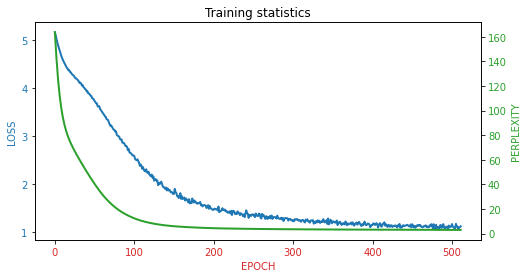

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()
ax1.set_xlabel('EPOCH', c='C3')
ax1.tick_params(axis='x', labelcolor='C3')
ax1.set_ylabel('LOSS', c='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.plot(stats.loss, lw=2, c='C0')
ax2.set_ylabel('PERPLEXITY', c='C2')
ax2.tick_params(axis='y', labelcolor='C2')
ax2.plot(stats.perplexity, lw=2, c='C2')
ax2.grid(False)
ax1.set_title("Training statistics")
None

In [ ]:
test_x = model_dict['test_x']
_, (emb_mean, emb_max) = model(test_x)

In [ ]:
X_emb_max = TSNE(n_components=2).fit_transform(emb_max.detach())

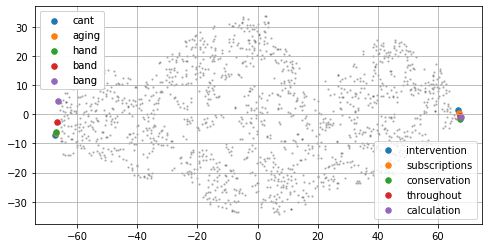

In [ ]:
# highlight = X_emb.argsort(axis=0)[:, 0][0::X_emb.shape[0]//7] # indexes of words to highlight
fig, _ = plt.subplots(figsize=(8, 4))
sort_ = X_emb_max.argsort(axis=0)[:, 0] # indexes of words to highlight

plt.grid(None)
plt.scatter(X_emb_max[:, 0], X_emb_max[:, 1], s=2, c='k', alpha=0.2)
grp1, grp2 = [], []
for i, word_index in enumerate(sort_[:5]):
    word = "".join(map(lambda e: str(chr(max(32, e))), test_x[word_index].tolist())).strip()
    p = plt.scatter(X_emb_max[word_index, 0], X_emb_max[word_index, 1], s=30, c=f"C{i}", alpha=1, label=word)
    grp1.append(p)


for i, word_index in enumerate(sort_[-5:]):
    word = "".join(map(lambda e: str(chr(max(32, e))), test_x[word_index].tolist())).strip()
    p = plt.scatter(X_emb_max[word_index, 0], X_emb_max[word_index, 1], s=30, c=f"C{i}", alpha=1, label=word)
    grp2.append(p)

plt.gca().add_artist(plt.legend(handles=grp1, loc='lower right'))
plt.gca().add_artist(plt.legend(handles=grp2, loc='upper left'))
None

In [ ]:
X_emb_mean = TSNE(n_components=2).fit_transform(emb_mean.detach())

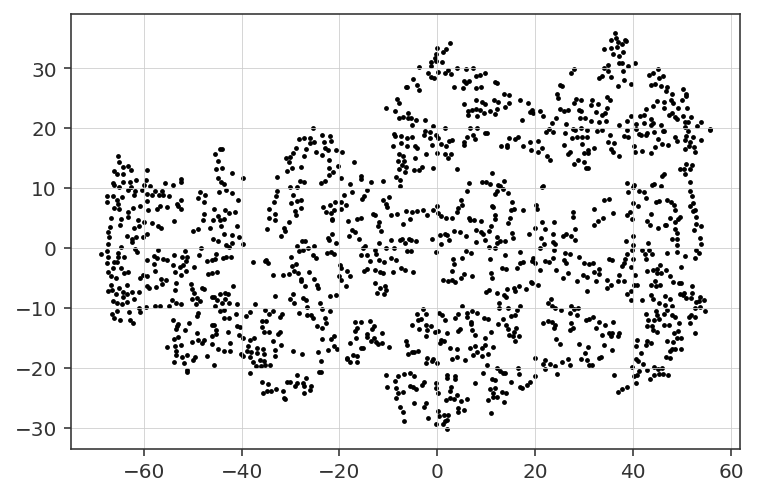

In [ ]:
plt.scatter(X_emb_mean[:, 0], X_emb_mean[:, 1], s=2, c='k', alpha=1)

# clustering = DBSCAN(eps=5, min_samples=1).fit(X_emb_mean)

# for i, label in enumerate(np.unique(clustering.labels_)):
#     mask = clustering.labels_ == label
#     plt.scatter(X_emb_mean[:,0][mask], X_emb_mean[:,1][mask], s=2, c=f"C{i}", alpha=1)
# plt.legend(list(map(lambda e: f"Cluster {e}", np.unique(clustering.labels_))), ncol=3)
# None

In [ ]:
# to_df = {i : [] for i in np.unique(clustering.labels_)}

# for i, label in enumerate(np.unique(clustering.labels_)):
#     mask = clustering.labels_ == label

#     for word_ in test_x[mask]:
#         word = "".join(map(lambda e: str(chr(max(32, e))), word_.tolist())).strip()
#         to_df[i].append(word)

# pd.DataFrame(list(map(lambda e: e[:5], to_df.values()))).T
# #pd.DataFrame(to_df)

,0
0,improvements
1,nervous
2,adjustable
3,biggest
4,update


In [ ]:
# Sample 10 words from the model starting with 'z'
for i in range(10):
    new_word = sample_sentence(model, "z", max_len = model_dict['args']['seq_length'], temperature = 0.2)
    print(new_word)

z
zont
zaee
zaaa
zins
zuno
zunn
zaae
zaae
z ce
